In [2]:
from cryoS2Sdrop.analyze import *
from cryoS2Sdrop.deconvolution import tom_deconv_tomo

deconv_kwargs = {
    "angpix": 10,
    "defocus": 0,
    "snrfalloff": 0.3,
    "deconvstrength": 1,
    "highpassnyquist": 0.02,
}

PARENT_PATH = setup.PARENT_PATH

pd.options.display.float_format = "{:,.6f}".format
pd.set_option('display.max_columns', 50)

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

# Tomo04

In [19]:
tomo_list = ['tomo04_dummy']

data_log = []

for tomo in tomo_list:
    logdir = 'data/S2SDenoising/model_logs/%s/fourierHFplusVolMask_comparison/' %tomo
    logdir = os.path.join(PARENT_PATH, logdir)

    _data_log = logdir_to_dataframe(logdir, clip_values=True, ignore_deconv=False)
    data_log.append(_data_log)

data_log = pd.concat(data_log)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,p,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline,noise_level
0,fourierHFplusVolMask_comparison,version_0,singleCET_FourierDataset,0,Fourier with mixed Mask,{'p': '0.5'},15.863437,0.345280,13.637398,0.272060,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.3,None,None,13.637398,0.272060,26.913320,NaN,16.323048,NaN,None
1,fourierHFplusVolMask_comparison,version_1,Unknown,0,None,None,NaN,NaN,NaN,NaN,None,None,None,None,None,0.5,None,None,13.637398,0.272060,NaN,NaN,NaN,NaN,None


,index,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,p,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline,noise_level
0,0,fourierHFplusVolMask_comparison,version_0,singleCET_FourierDataset,0,Fourier with mixed Mask,{'p': '0.5'},15.863437,0.345280,13.637398,0.272060,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.3,None,None,13.637398,0.272060,26.913320,NaN,16.323048,NaN,None


AttributeError: 'Series' object has no attribute 'pred_path'

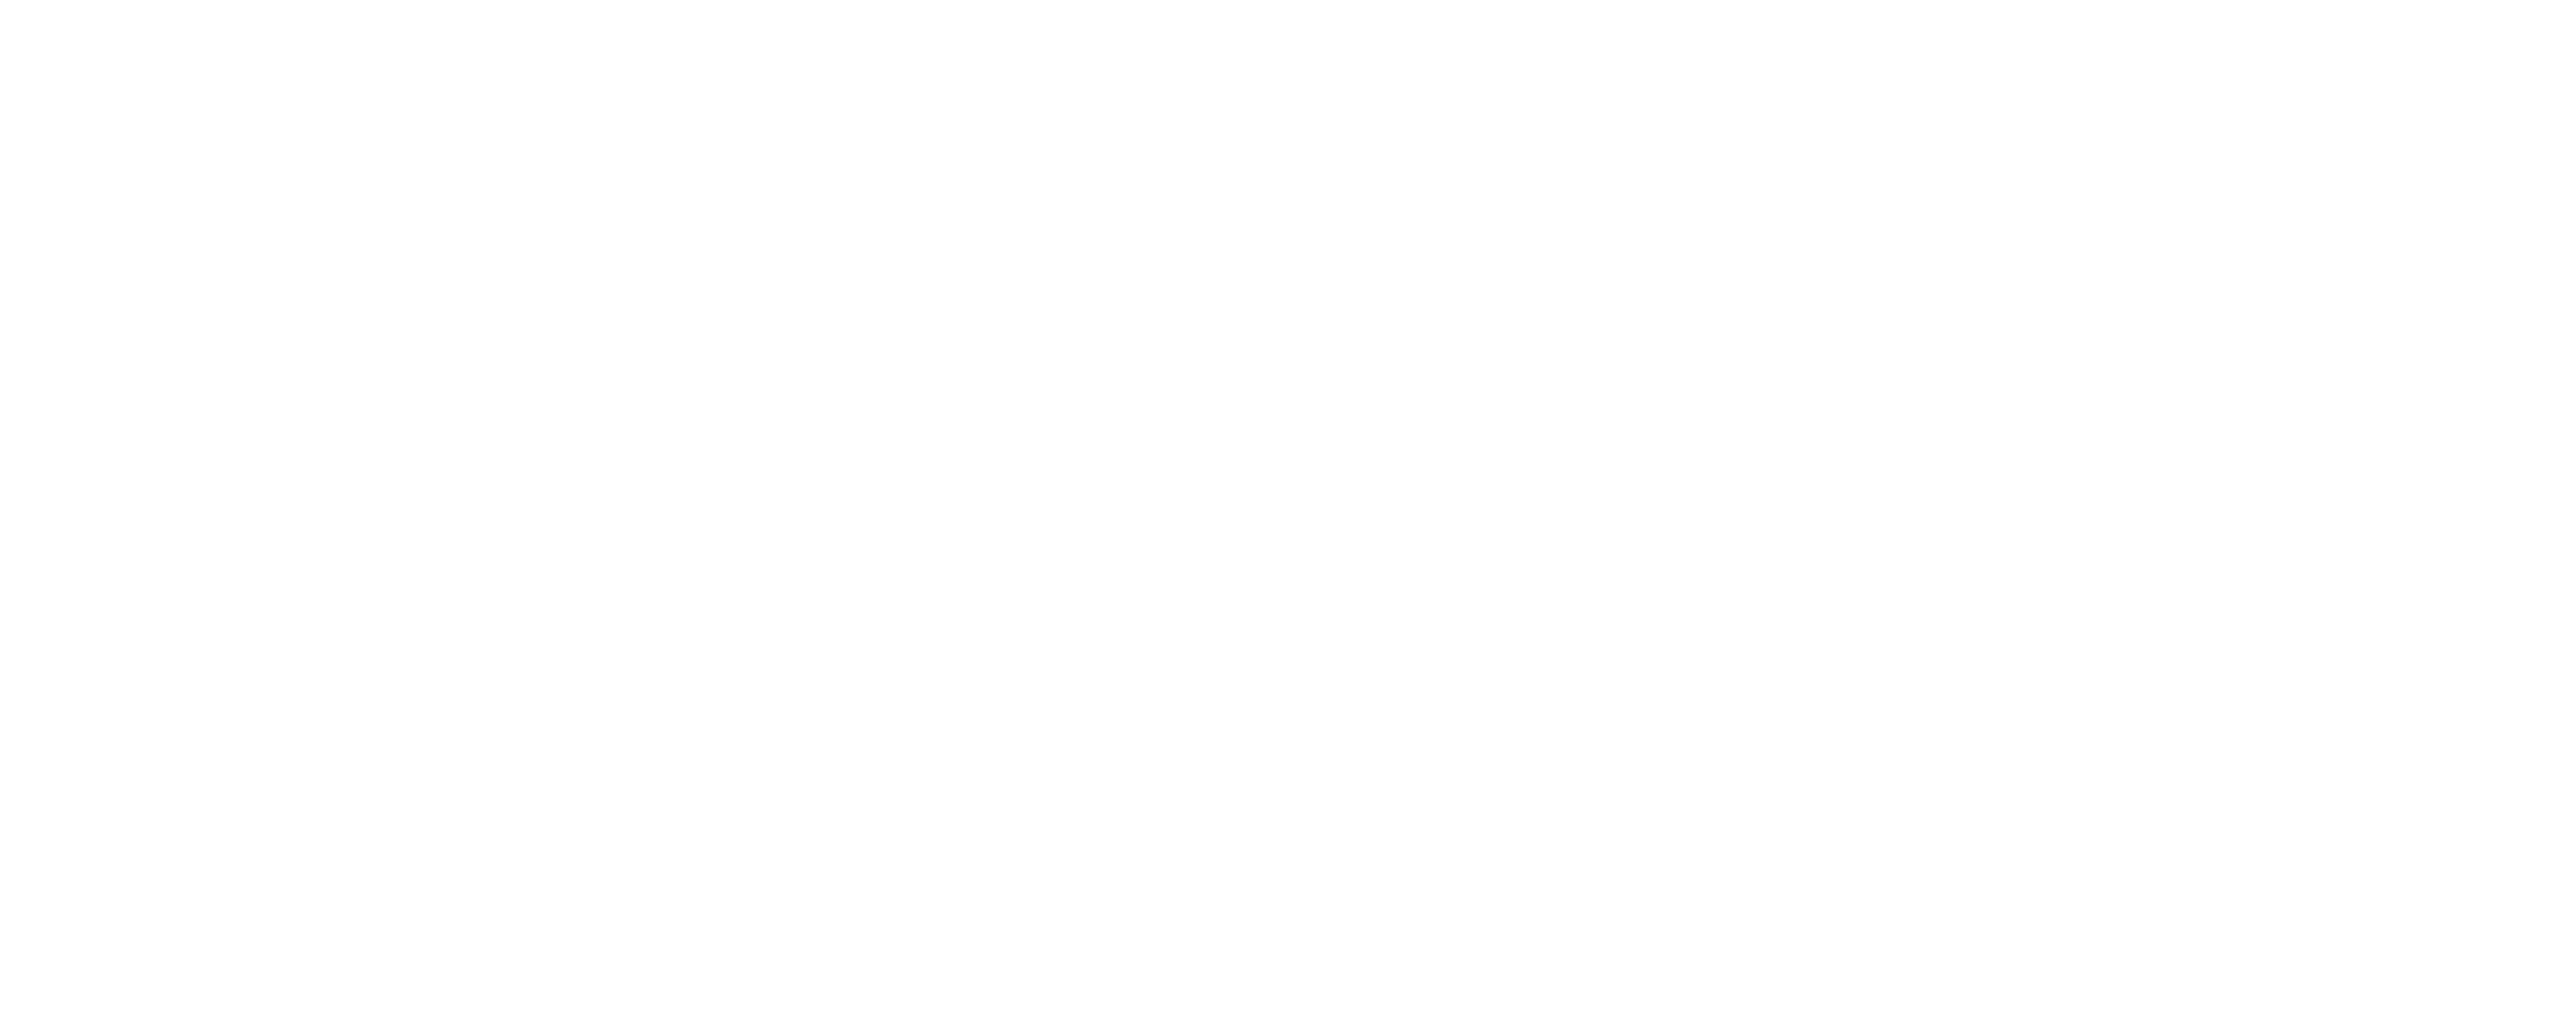

In [20]:
idx = data_log.groupby(['use_deconv_data', 'p'])['full_tomo_ssim'].transform(max) == data_log['full_tomo_ssim']

df = data_log[idx].reset_index()

display(df)

fig, ax = plt.subplots(2, len(df)+1, figsize=(20, 8), dpi=140)
list(map(lambda axi: axi.set_axis_off(), ax.ravel()))
plt.tight_layout()

for i, row in df.iterrows():
    gt = read_array(row.gt_tomo_path)
    gt = standardize(clip(gt))
    gt = scale(gt)
    noisy = read_array(row.tomo_path)
    noisy = standardize(clip(noisy))
    noisy = scale(noisy)
    if row.use_deconv_data=="true":
        noisy = tom_deconv_tomo(**{"vol": noisy, **deconv_kwargs})
    
    denoised = read_array(row.pred_path)
    denoised = scale(denoised)
    
    zidx = len(gt)//2
    
    # print(row.pred_path, '\n')
    
    ax[1][0].imshow(gt[zidx], vmin=0, vmax=1)
    ax[1][0].set_title('Ground Truth', size=20)
    ax_noisy = ax[0][i+1]
    ax_denoised = ax[1][i+1]
    ax_noisy.imshow(noisy[zidx], vmin=0, vmax=1)
    ax_denoised.imshow(denoised[zidx], vmin=0, vmax=1)
    
    _ssim = ssim(torch.tensor(gt[zidx]).unsqueeze(0).unsqueeze(0),
                 torch.tensor(denoised[zidx]).unsqueeze(0).unsqueeze(0), 
                 data_range=1)
    
    _psnr = peak_signal_noise_ratio(torch.tensor(gt[zidx]).unsqueeze(0).unsqueeze(0),
                 torch.tensor(denoised[zidx]).unsqueeze(0).unsqueeze(0), 
                 data_range=1)
    
    ax_noisy.text(0.0125, 0.93, string.ascii_lowercase[i]+')', transform=ax_noisy.transAxes, size=20, weight='bold', color='white')
    ax_denoised.text(0.0125, 0.02, 'SSIM: %.02f' %float(_ssim), transform=ax_denoised.transAxes, size=20, color='white')
    ax_denoised.text(0.5+2*0.0125, 0.02, 'PSNR: %.02f' %float(_psnr), transform=ax_denoised.transAxes, size=20, color='white')

In [ ]:
df = data_log.groupby(['use_deconv_data', 'p'])['full_tomo_ssim', 'full_tomo_psnr'].mean().reset_index()

df2 = data_log.groupby(['use_deconv_data'])['n2v_ssim', 'n2v_psnr'].mean().reset_index()
df2['p'] = 'N2V Ref'
df2 = df2[['use_deconv_data', 'p', 'n2v_ssim', 'n2v_psnr']]
df2.columns = ['use_deconv_data', 'p', 'full_tomo_ssim', 'full_tomo_psnr']

df = pd.concat([df, df2])

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 4), sharex=True, dpi=140)

plt.tight_layout()
name = data_log.gt_tomo_path.unique()[0].split('/')[-1].replace('.mrc', '')

if name == 'tomoPhantom_model14':
    name = '"cell" model'
if name == 'tomoPhantom_model16':
    name = '"spaceship" model'
if name == 'tomoPhantom_model8':
    name = '"blobs" model'
    
plt.suptitle('Denoising metrics for the %s' %name, y=1.01)

sns.barplot(data=df, hue='p', y='full_tomo_ssim', x='use_deconv_data', ax=ax0, alpha=0.8)
ax0.set_xlabel('')
sns.barplot(data=df, hue='p', y='full_tomo_psnr', x='use_deconv_data', ax=ax1, alpha=0.8)
ax1.set_xlabel('Deconvolved')

ax0.set_ylabel('Full tomogram SSIM', fontsize=10)
ax1.set_ylabel('Full tomogram PSNR', fontsize=10)
ax0.legend(bbox_to_anchor=(1, 1))
ax1.get_legend().remove()

# Tomo02

In [22]:
tomo_list = ['tomo02_dummy']

data_log = []

for tomo in tomo_list:
    logdir = 'data/S2SDenoising/model_logs/%s/fourierHFplusVolMask_comparison/' %tomo
    logdir = os.path.join(PARENT_PATH, logdir)

    _data_log = logdir_to_dataframe(logdir, clip_values=True, ignore_deconv=False)
    data_log.append(_data_log)

data_log = pd.concat(data_log)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,p,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline,noise_level,tomo_name,pred_path
0,fourierHFplusVolMask_comparison,version_0,singleCET_FourierDataset,0,Fourier with mixed Mask,{'p': '0.5'},16.538216,0.404477,13.907833,0.336667,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.3,None,None,13.907833,0.336667,20.141615,NaN,18.912957,NaN,None,tomo02_dummy,/home/ubuntu/Thesis/data/S2SDenoising/model_lo...
1,fourierHFplusVolMask_comparison,version_1,singleCET_FourierDataset,0,Fourier with mixed Mask,{'p': '0.5'},15.668243,0.385675,13.907833,0.336667,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.5,None,None,13.907833,0.336667,14.556881,NaN,12.657689,NaN,None,tomo02_dummy,/home/ubuntu/Thesis/data/S2SDenoising/model_lo...


,index,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,p,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline,noise_level,tomo_name,pred_path
0,0,fourierHFplusVolMask_comparison,version_0,singleCET_FourierDataset,0,Fourier with mixed Mask,{'p': '0.5'},16.538216,0.404477,13.907833,0.336667,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.3,None,None,13.907833,0.336667,20.141615,NaN,18.912957,NaN,None,tomo02_dummy,/home/ubuntu/Thesis/data/S2SDenoising/model_lo...
1,1,fourierHFplusVolMask_comparison,version_1,singleCET_FourierDataset,0,Fourier with mixed Mask,{'p': '0.5'},15.668243,0.385675,13.907833,0.336667,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.5,None,None,13.907833,0.336667,14.556881,NaN,12.657689,NaN,None,tomo02_dummy,/home/ubuntu/Thesis/data/S2SDenoising/model_lo...


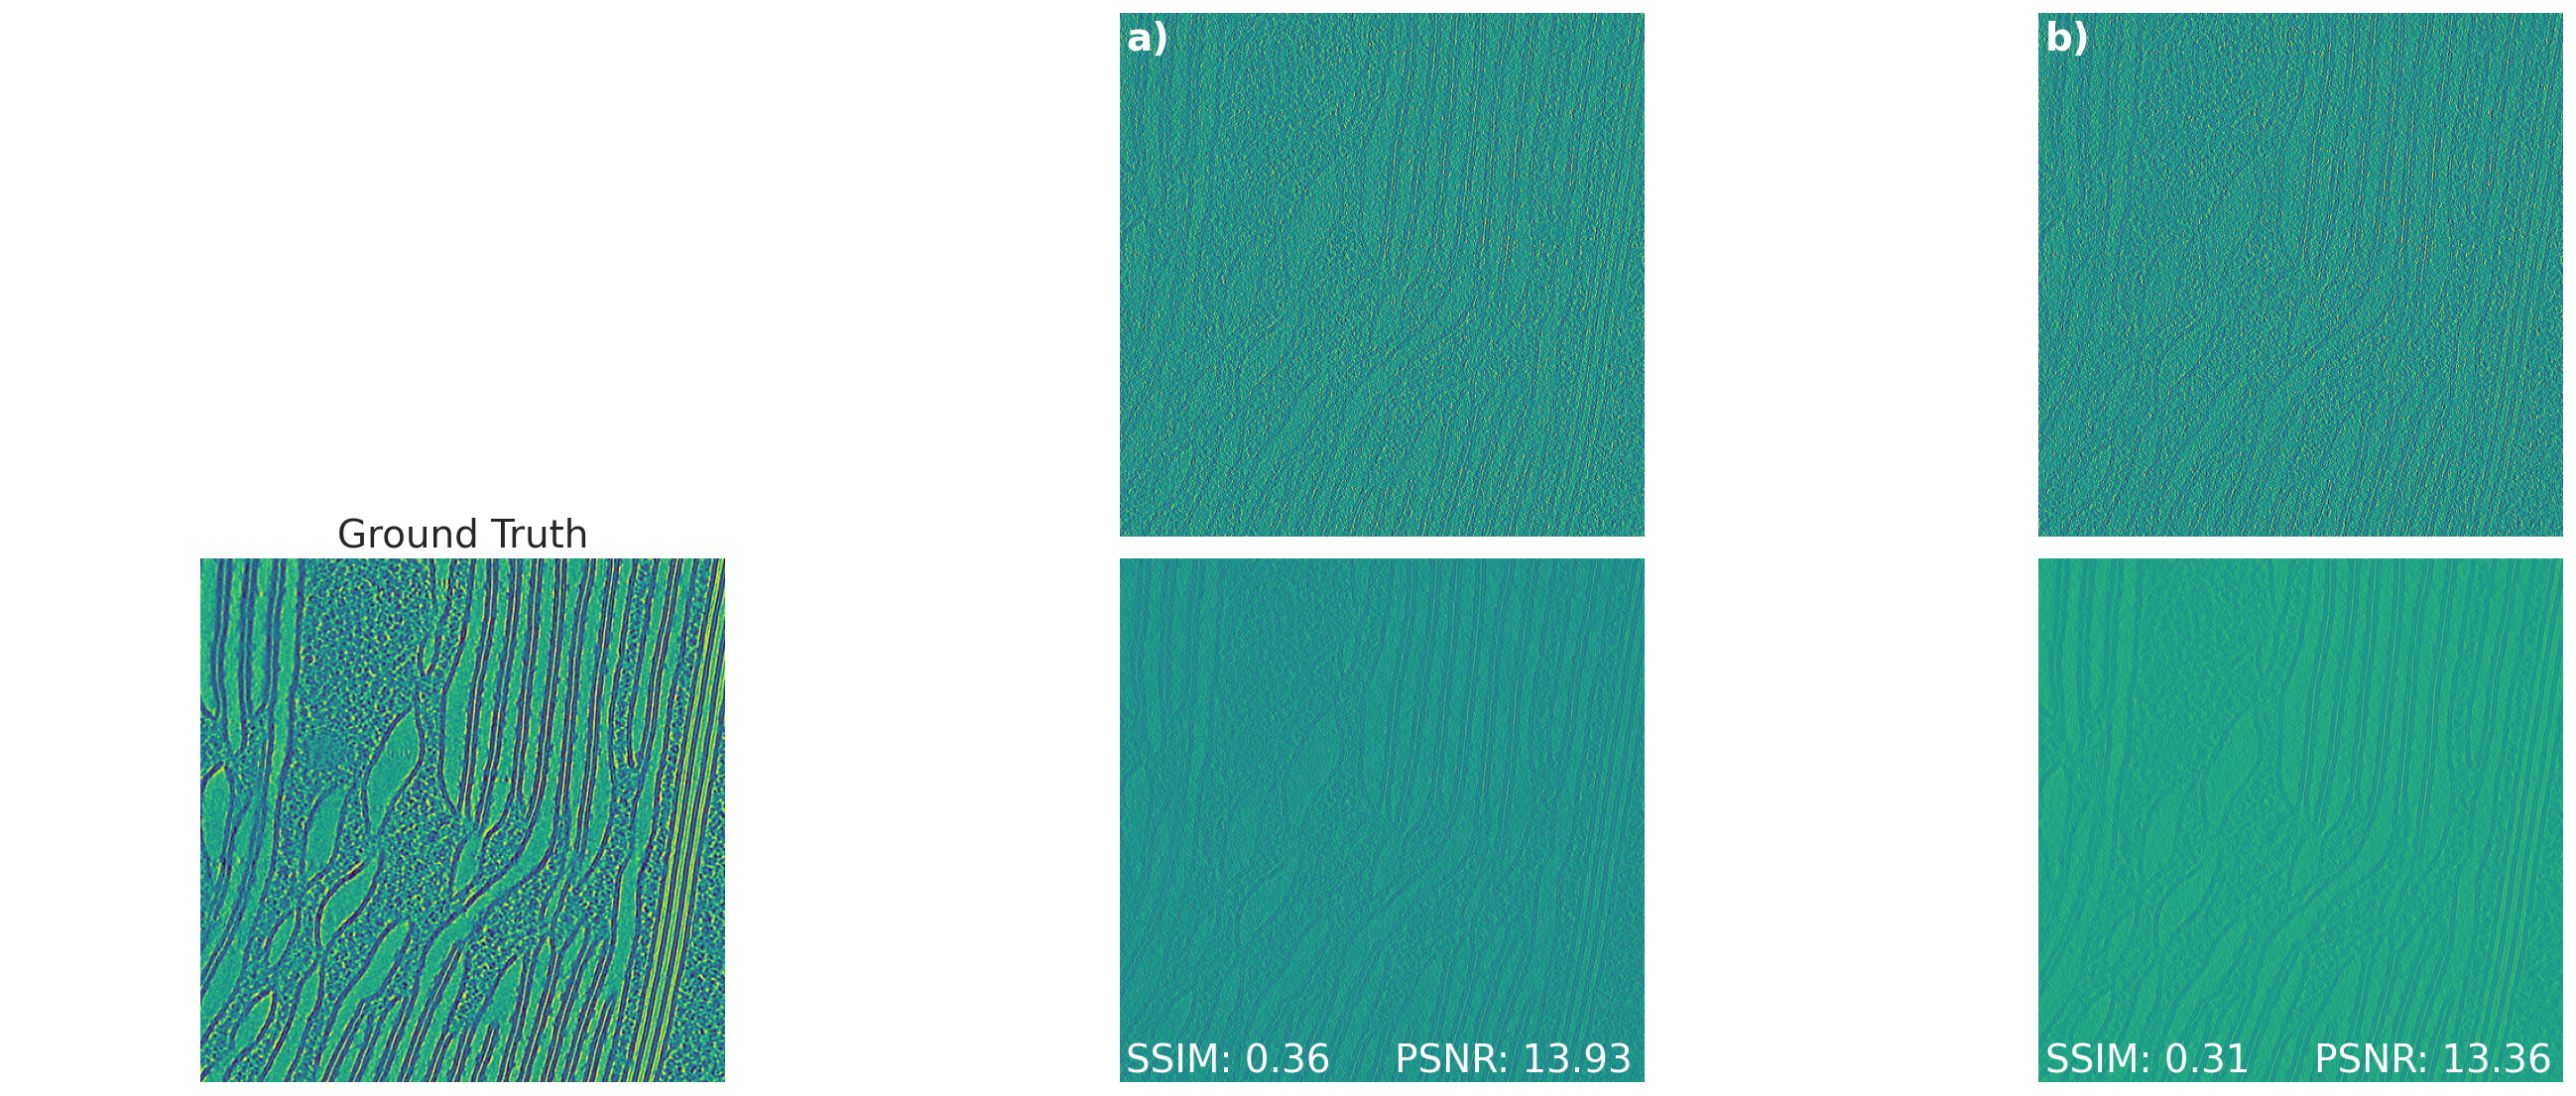

In [23]:
idx = data_log.groupby(['use_deconv_data', 'p'])['full_tomo_ssim'].transform(max) == data_log['full_tomo_ssim']

df = data_log[idx].reset_index()

display(df)

fig, ax = plt.subplots(2, len(df)+1, figsize=(20, 8), dpi=140)
list(map(lambda axi: axi.set_axis_off(), ax.ravel()))
plt.tight_layout()

for i, row in df.iterrows():
    gt = read_array(row.gt_tomo_path)
    gt = standardize(clip(gt))
    gt = scale(gt)
    noisy = read_array(row.tomo_path)
    noisy = standardize(clip(noisy))
    noisy = scale(noisy)
    if row.use_deconv_data=="true":
        noisy = tom_deconv_tomo(**{"vol": noisy, **deconv_kwargs})
    
    denoised = read_array(row.pred_path)
    denoised = scale(denoised)
    
    zidx = len(gt)//2
    
    # print(row.pred_path, '\n')
    
    ax[1][0].imshow(gt[zidx], vmin=0, vmax=1)
    ax[1][0].set_title('Ground Truth', size=20)
    ax_noisy = ax[0][i+1]
    ax_denoised = ax[1][i+1]
    ax_noisy.imshow(noisy[zidx], vmin=0, vmax=1)
    ax_denoised.imshow(denoised[zidx], vmin=0, vmax=1)
    
    _ssim = ssim(torch.tensor(gt[zidx]).unsqueeze(0).unsqueeze(0),
                 torch.tensor(denoised[zidx]).unsqueeze(0).unsqueeze(0), 
                 data_range=1)
    
    _psnr = peak_signal_noise_ratio(torch.tensor(gt[zidx]).unsqueeze(0).unsqueeze(0),
                 torch.tensor(denoised[zidx]).unsqueeze(0).unsqueeze(0), 
                 data_range=1)
    
    ax_noisy.text(0.0125, 0.93, string.ascii_lowercase[i]+')', transform=ax_noisy.transAxes, size=20, weight='bold', color='white')
    ax_denoised.text(0.0125, 0.02, 'SSIM: %.02f' %float(_ssim), transform=ax_denoised.transAxes, size=20, color='white')
    ax_denoised.text(0.5+2*0.0125, 0.02, 'PSNR: %.02f' %float(_psnr), transform=ax_denoised.transAxes, size=20, color='white')

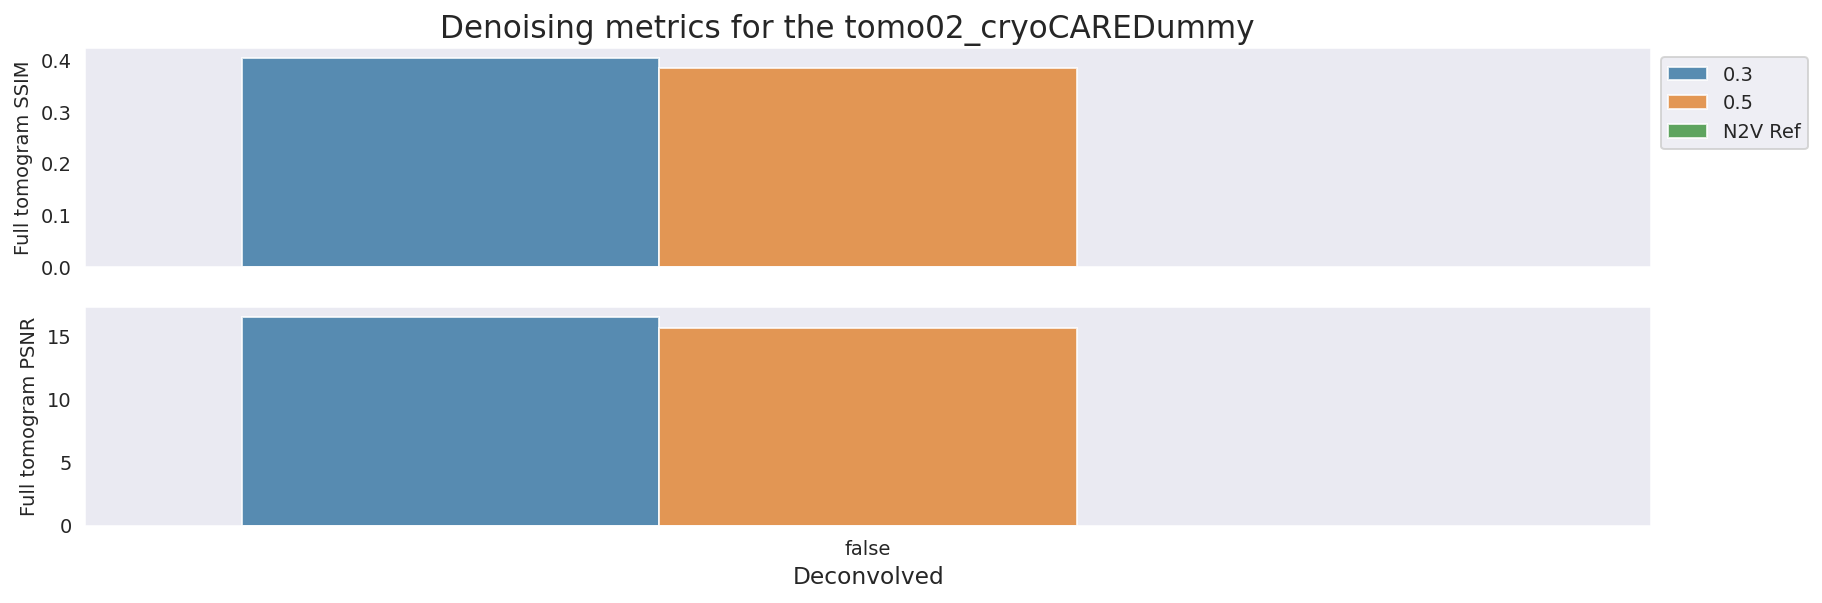

In [24]:
df = data_log.groupby(['use_deconv_data', 'p'])['full_tomo_ssim', 'full_tomo_psnr'].mean().reset_index()

df2 = data_log.groupby(['use_deconv_data'])['n2v_ssim', 'n2v_psnr'].mean().reset_index()
df2['p'] = 'N2V Ref'
df2 = df2[['use_deconv_data', 'p', 'n2v_ssim', 'n2v_psnr']]
df2.columns = ['use_deconv_data', 'p', 'full_tomo_ssim', 'full_tomo_psnr']

df = pd.concat([df, df2])

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 4), sharex=True, dpi=140)

plt.tight_layout()
name = data_log.gt_tomo_path.unique()[0].split('/')[-1].replace('.mrc', '')

if name == 'tomoPhantom_model14':
    name = '"cell" model'
if name == 'tomoPhantom_model16':
    name = '"spaceship" model'
if name == 'tomoPhantom_model8':
    name = '"blobs" model'
    
plt.suptitle('Denoising metrics for the %s' %name, y=1.01)

sns.barplot(data=df, hue='p', y='full_tomo_ssim', x='use_deconv_data', ax=ax0, alpha=0.8)
ax0.set_xlabel('')
sns.barplot(data=df, hue='p', y='full_tomo_psnr', x='use_deconv_data', ax=ax1, alpha=0.8)
ax1.set_xlabel('Deconvolved')

ax0.set_ylabel('Full tomogram SSIM', fontsize=10)
ax1.set_ylabel('Full tomogram PSNR', fontsize=10)
ax0.legend(bbox_to_anchor=(1, 1))
ax1.get_legend().remove()